In [ ]:
import pandas as pd
import numpy as np
import cupy as cp
import random
import time

In [ ]:
dataset = pd.read_csv("sample_data/mnist_train_small.csv", header=None)

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [ ]:
X = np.array(dataset.iloc[:, 1:]) / 255
Y = np.array(dataset.iloc[:, 0])
def get_batches(X, Y, batch_size):
    for i in range(0, len(X), batch_size):
        yield X[i:i+batch_size], Y[i:i+batch_size]

In [ ]:
def predict(x, w, b, layers):
    x = x.reshape(-1, 1)
    for i in range(1, layers + 1):
        z = np.dot(w[i], x) + b[i]
        x = sigmoid(z)
    return np.argmax(x)

In [ ]:
def accuracy_test(w,b):
    df_test = pd.read_csv("sample_data/mnist_test.csv", header=None)
    X_test = np.array(df_test.iloc[:, 1:]) / 255
    Y_test = np.array(df_test.iloc[:, 0])
    total = 0
    correct = 0
    for i in range(len(X_test)):
        if predict(X[i], w, b, 2) == Y[i]:
            correct += 1
        total += 1
    return correct/total*100


In [ ]:
def cost_computation(X, Y, w, b, layers):
    costs = []
    for x, y in zip(X,Y):
        y_ = np.zeros(shape=[10, 1])
        y_[y] = 1
        x = x.reshape(-1, 1)
        for i in range(1, layers + 1):
            z = np.dot(w[i], x) + b[i]
            x = sigmoid(z)
        costs.append((x - y) ** 2)
    return np.mean(costs)


In [ ]:
batch_size = 100
layers = 2
epochs = 25
costs = np.zeros(epochs)
accuracy = np.zeros(epochs)
#to make weights and biases one indexed
#xavier initializattion
w = [None, np.random.randn(16, 784) * np.sqrt(1.0 / (784)),
        np.random.randn(10, 16) * np.sqrt(1.0 / (16))]
b = [None, np.random.rand(16, 1), np.random.rand(10, 1)]

In [ ]:
for e in range(epochs):
    for batch in get_batches(X, Y, batch_size):
        w_pds = []
        b_pds = []
        for k in range(batch_size):
            x = batch[0][k].reshape(-1, 1)
            y = batch[1][k]
            y_ = np.zeros(shape=[10, 1])
            y_[y] = 1
            z = [x]
            a = [x]

            for i in range(1, layers + 1):
                z_new = np.dot(w[i], a[i - 1]) + b[i]
                z.append(z_new)
                a.append(sigmoid(z_new))
            prev_delcdela = 2*(a[-1] - y_)
            w_pd = []
            b_pd = []
            for l in range(layers, 0, -1):
                delta = prev_delcdela * sigmoid_prime(z[l])
                w_pd.append(np.dot(delta, a[l - 1].T))
                b_pd.append(delta)
                prev_delcdela = np.dot(w[l].T, delta)
            w_pds.append(w_pd)
            b_pds.append(b_pd)
        delc_delw = []
        delc_delb = []
        for layer in range(layers):
            sum = np.zeros_like(w_pds[0][layer])
            for w_pd in w_pds:
                sum += w_pd[layer]
            delc_delw.append(sum / batch_size)
            sum = np.zeros_like(b_pds[0][layer])
            for b_pd in b_pds:
                sum += b_pd[layer]
            delc_delb.append(sum / batch_size)
        delc_delw = [None] + delc_delw[::-1]
        delc_delb = [None] + delc_delb[::-1]
        #update w and b
        eta = 0.00001
        for i in range(1, layers + 1):
            w[i] -= eta*delc_delw[i]
            b[i] -= eta*delc_delb[i]
    #computing accuracy
    accuracy[e] = accuracy_test(w, b)
    costs[e] = cost_computation(X, Y, w, b, layers)



KeyboardInterrupt: 

27.500000000000004


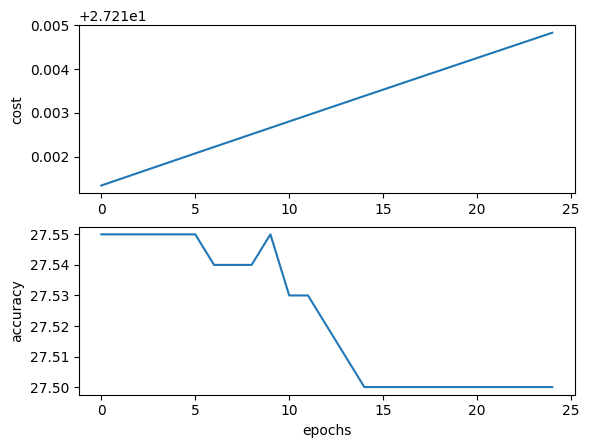

In [ ]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(2)
ax1[0].plot(costs)
ax1[0].set_ylabel("cost")
ax1[1].plot(accuracy)
ax1[1].set_ylabel("accuracy")
ax1[1].set_xlabel("epochs")
fig.show()
print(accuracy[-1])

# 86% accurate, not bad!

In [ ]:
df_test = pd.read_csv("sample_data/mnist_test.csv", header=None)

prediction:-  7


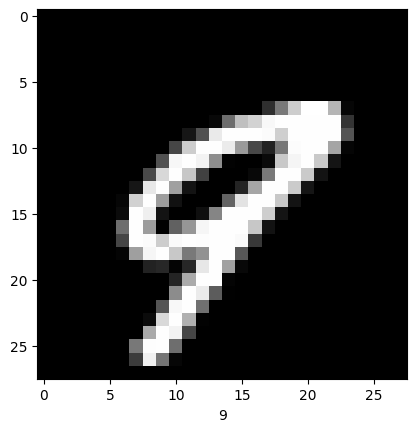

In [ ]:
fig, ax = plt.subplots(1)
n = 9741
ax.imshow(X_test[n].reshape(28, 28), cmap="gray")
ax.set_xlabel(Y_test[n])
fig.show()
print("prediction:- ", predict(X_test[n], w, b, 2))

In [ ]:
df_train = pd.read_csv("sample_data/mnist_train_small.csv")
df_test = pd.read_csv("sample_data/mnist_test.csv")

# train_data is a list of tuples (x, y) where x is (784, 1) and y is (10, 1)
train_data = []
test_data = []
for i in range(len(df_train)):
    x = cp.array(df_train.iloc[i, 1:])
    x = x.reshape(-1, 1)
    y = df_train.iloc[i, 0]
    y_ = cp.zeros(shape=[10, 1])
    y_[y] = 1
    train_data.append((x, y_))
for i in range(len(df_test)):
    x = cp.array(df_test.iloc[i, 1:])
    x = x.reshape(-1, 1)
    y = df_test.iloc[i, 0]
    y_ = cp.zeros(shape=[10, 1])
    y_[y] = 1
    test_data.append((x, y_))




In [ ]:
df_train = pd.read_csv("sample_data/mnist_train_small.csv")
df_test = pd.read_csv("sample_data/mnist_test.csv")

# train_data is a list of tuples (x, y) where x is (784, 1) and y is (10, 1)
train_data_np = []
test_data_np = []
for i in range(len(df_train)):
    x = np.array(df_train.iloc[i, 1:])
    x = x.reshape(-1, 1)
    y = df_train.iloc[i, 0]
    y_ = np.zeros(shape=[10, 1])
    y_[y] = 1
    train_data_np.append((x, y_))
for i in range(len(df_test)):
    x = np.array(df_test.iloc[i, 1:])
    x = x.reshape(-1, 1)
    y = df_test.iloc[i, 0]
    y_ = np.zeros(shape=[10, 1])
    y_[y] = 1
    test_data_np.append((x, y_))




In [ ]:
class Network:
    def __init__(self, sizes):
        self.num_layers = len(sizes) - 1
        self.sizes = sizes
        self.weights = [np.random.randn(n_out, n_in) * np.sqrt(2.0 / (n_in + n_out)) for n_in, n_out in zip(sizes[:-1], sizes[1:])]
        self.biases = [np.random.randn(n, 1) for n in sizes[1:]]
    def feedForward(self, x):
        z = []
        a = [x]
        for weight, bias in zip(self.weights, self.biases):
            z_new = np.dot(weight, a[-1]) + bias
            z.append(z_new)
            x = sigmoid(z_new)
            a.append(x)
        return (z, a)
    def SGD(self, train_data, batch_size, epochs, eta, test_data=None):
        # train_data = list of tuples
        self.accuracies = np.zeros(epochs)
        self.costs = np.zeros(epochs)
        def get_batches(train_data, batch_size):
            random.shuffle(train_data)
            for i in range(0, len(train_data), batch_size):
                yield train_data[i:i+batch_size]

        for e in range(epochs):
            for batch in get_batches(train_data, batch_size):
                self.update_mini_batch(batch, eta)
            if(test_data):
                self.accuracies[e] = self.accuracy_test(test_data)
                self.costs[e] = self.cost_computation(test_data)
            print(f"epoch {e} done")

    def update_mini_batch(self, batch, eta):
        batch_size = len(batch)
        delta_w = [np.zeros_like(w) for w in self.weights]
        delta_b = [np.zeros_like(b) for b in self.biases]
        for x, y in batch:
            delta_w_sample, delta_b_sample = self.backprop(x, y)
            delta_w = [dw_sum + sample for dw_sum, sample in zip(delta_w, delta_w_sample)]
            delta_b = [db_sum + sample for db_sum, sample in zip(delta_b, delta_b_sample)]
        delta_w = [dw / batch_size for dw in delta_w]
        delta_b = [db / batch_size for db in delta_b]

        self.weights = [weight - eta * dw for weight, dw in zip(self.weights, delta_w)]
        self.biases = [bias - eta * db for bias, db in zip(self.biases, delta_b)]

    def backprop(self, x, y):
        z, a = self.feedForward(x)
        delta_w_sample = [np.zeros_like(w) for w in self.weights]
        delta_b_sample = [np.zeros_like(b) for b in self.biases]
        delta = sigmoid_prime(z[-1]) * self.cost_derivative(a[-1], y)
        for i in range(self.num_layers - 1, -1, -1):
            delta_w_sample[i] = np.dot(delta, a[i].T)
            delta_b_sample[i] = delta
            if i > 0:
                delta = np.dot(self.weights[i].T, delta) * sigmoid_prime(z[i - 1])
        return (delta_w_sample, delta_b_sample)

    def accuracy_test(self, test_data):
        sum_ = 0
        for x, y in test_data:
            a = self.feedForward(x)[1][-1]
            if np.argmax(a) == np.argmax(y):
                sum_ += 1
        return sum_ / len(test_data)


    def cost_computation(self, test_data):
        costs = [self.cost(self.feedForward(x)[1][-1], y) for x, y in test_data]
        return np.mean(costs)

    def cost_derivative(self, a, y):
        return 2 * (a - y)

    def cost(self, a, y):
        return (a - y) ** 2

In [ ]:
neural_net = Network([784, 128, 64, 10])
neural_net.SGD(train_data_np, 100, 40, 0.225, test_data=test_data_np)

91.55915591559156


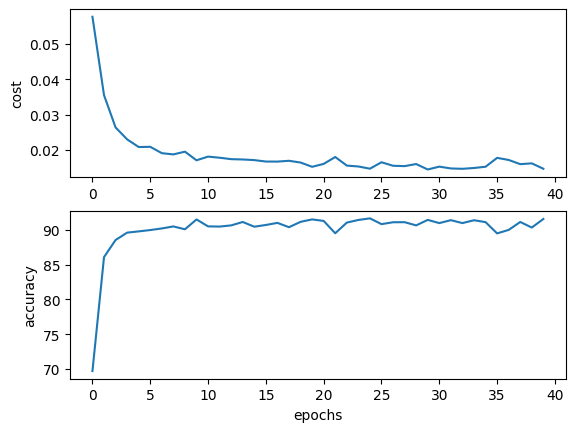

In [ ]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(2)
ax1[0].plot(neural_net.costs)
ax1[0].set_ylabel("cost")
ax1[1].plot(neural_net.accuracies*100)
ax1[1].set_ylabel("accuracy")
ax1[1].set_xlabel("epochs")
fig.show()
print(neural_net.accuracies[-1]*100)

### ig that's as far as we can go
# 91.56%

<ipython-input-13-89c811dc9afc>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


3


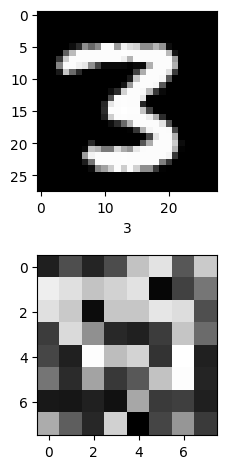

In [ ]:
fig, ax = plt.subplots(2)
n = 9156
dp = test_data_np[n]
ax[0].imshow(dp[0].reshape(28, 28), cmap="gray")
ax[0].set_xlabel(np.argmax(dp[1]))
fig.tight_layout()
fig.show()

result = neural_net.feedForward(dp[0])

ax[1].imshow(result[1][-2].reshape(8,8), cmap="gray")
print(np.argmax(result[1][-1]))

# .

In [ ]:
class Network_ideal(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            time1 = time.time()
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            time2 = time.time()
            if test_data:
                print("Epoch {0}: {1} / {2}, took {3:.2f} seconds".format(
                    j, self.evaluate(test_data), n_test, time2-time1))
            else:
                print("Epoch {0} complete in {1:.2f} seconds".format(j, time2-time1))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)


In [ ]:
nn = Network_ideal([784, 16, 10])

In [ ]:
nn.SGD(train_data_np, 10, 1000, 0.1, test_data=test_data_np)

<ipython-input-2-89c811dc9afc>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 0: 1072 / 9999, took 2.28 seconds
Epoch 1: 1049 / 9999, took 1.43 seconds
Epoch 2: 1017 / 9999, took 1.41 seconds
Epoch 3: 1014 / 9999, took 1.40 seconds
Epoch 4: 1072 / 9999, took 1.43 seconds
Epoch 5: 1141 / 9999, took 1.43 seconds
Epoch 6: 1164 / 9999, took 1.41 seconds
Epoch 7: 1170 / 9999, took 2.33 seconds
Epoch 8: 1177 / 9999, took 1.40 seconds
Epoch 9: 1218 / 9999, took 1.39 seconds


In [ ]:
neural_net.accuracies

AttributeError: 'Network_ideal' object has no attribute 'accuracy'

In [ ]:
class Network_gpu:
    def __init__(self, sizes):
        self.num_layers = len(sizes) - 1
        self.sizes = sizes
        self.weights = [cp.random.randn(n_out, n_in) * cp.sqrt(2.0 / (n_in + n_out)) for n_in, n_out in zip(sizes[:-1], sizes[1:])]
        self.biases = [cp.random.randn(n, 1) for n in sizes[1:]]
    def feedForward(self, x):
        z = []
        a = [x]
        for weight, bias in zip(self.weights, self.biases):
            # print(weight.shape, a[-1].shape, bias.shape)
            z_new = cp.dot(weight, a[-1]) + bias
            z.append(z_new)
            x = sigmoid(z_new)
            a.append(x)
        return (z, a)
    def SGD(self, train_data, batch_size, epochs, eta, test_data=None):
        # train_data = list of tuples
        self.accuracies = cp.zeros(epochs)
        def get_batches(train_data, batch_size):
            random.shuffle(train_data)
            batches = []
            for i in range(0, len(train_data), batch_size):
                batch = train_data[i:i+batch_size]
                x_batch = cp.hstack([x for x, y in batch])  # shape: (input_size, batch_size)
                y_batch = cp.hstack([y for x, y in batch])
                batches.append((x_batch, y_batch))
            # print(batches[0][0].shape, batches[0][1].shape)
            return batches


        for e in range(epochs):
            batches = get_batches(train_data, batch_size)
            for batch in batches:
                self.update_mini_batch(batch, eta)
            if(test_data):
                self.accuracies[e] = self.accuracy_test(test_data)
            print(f"epoch {e} done")

    def update_mini_batch(self, batch, eta):
        x_batch, y_batch = batch
        batch_size = x_batch.shape[1]

        delta_w, delta_b = self.backprop(x_batch, y_batch)

        self.weights = [w - eta * dw / batch_size for w, dw in zip(self.weights, delta_w)]
        self.biases = [b - eta * db / batch_size for b, db in zip(self.biases, delta_b)]

    def backprop(self, x, y):
        batch_size = x.shape[1]
        z, a = self.feedForward(x)
        delta_w = [cp.zeros_like(w) for w in self.weights]
        delta_b = [cp.zeros_like(b) for b in self.biases]

        # Last layer error
        delta = sigmoid_prime(z[-1]) * self.cost_derivative(a[-1], y)
        # delta_w[-1] = cp.dot(delta, a[-2].T)
        # delta_b[-1] = cp.sum(delta, axis=1, keepdims=True)

        # Propagate backwards
        # for i in range(self.num_layers - 2, -1, -1):
        #     delta = cp.dot(self.weights[i+1].T, delta) * sigmoid_prime(z[i])
        #     delta_w[i] = cp.dot(delta, a[i].T)
        #     delta_b[i] = cp.sum(delta, axis=1, keepdims=True)

        for i in range(self.num_layers - 1, -1, -1):
            delta_w[i] = cp.dot(delta, a[i].T) / batch_size
            delta_b[i] = cp.sum(delta, axis=1, keepdims=True) / batch_size
            if i > 0:
                delta = cp.dot(self.weights[i].T, delta) * sigmoid_prime(z[i - 1])

        return (delta_w, delta_b)




    def accuracy_test(self, test_data):
        test_result = [(cp.argmax(self.feedForward(x)[1][-1]), cp.argmax(y)) for x, y in test_data]
        return sum(int(x == y) for (x, y) in test_result) / len(test_data)

    def cost_derivative(self, a, y):
        return 2 * (a - y)

In [ ]:
nn_gpu = Network_gpu([784, 16, 16, 10])

In [ ]:
nn_gpu.SGD(train_data, 100, 10, 0.01, test_data=test_data)

epoch 0 done
epoch 1 done
epoch 2 done
epoch 3 done
epoch 4 done
epoch 5 done
epoch 6 done
epoch 7 done
epoch 8 done


In [ ]:
len(train_data)

19999

In [ ]:
nn_gpu.accuracies

array([0.09580958, 0.09580958, 0.09580958, 0.09580958, 0.09580958,
       0.09580958, 0.09580958, 0.09580958, 0.09580958, 0.09580958])